In [3]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet50

from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
DIR_TRAIN = "data/train/"
DIR_VAL = "data/val/"

In [5]:
train_imgs = os.listdir(DIR_TRAIN) 
val_imgs = os.listdir(DIR_VAL)

In [6]:
print(train_imgs[:5])
print(val_imgs[:5])

['F2F.0.png', 'F2F.1.png', 'F2F.2.png', 'F2F.3.png', 'F2F.4.png']
['F2F.0.png', 'F2F.1.png', 'F2F.2.png', 'F2F.3.png', 'F2F.4.png']


In [7]:
def get_train_transform():
    return T.Compose([
        T.RandomHorizontalFlip(p=0.5),
        T.RandomRotation(15),
        T.RandomCrop(204),
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])
    
def get_val_transform():
    return T.Compose([
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])

In [51]:
class DeepFakeDataset(Dataset):
    def __init__(self, imgs, mode = "train", transforms = None):
        super().__init__()
        self.imgs = imgs
        self.mode = mode
        self.transforms = transforms
    
    def __getitem__(self, idx):
        image_name = self.imgs[idx]
        
        
        # Training
        if self.mode == "train":
            img = Image.open(DIR_TRAIN + image_name)
            img = img.resize((224, 224))
            
            # Prepare class label
            if (image_name.split(".")[0] == "original"):
                label = 1 # It is original
            else:
                label = 0 # It is fake
            
            label = torch.tensor(label, dtype = torch.float32)
            
            ### Apply Transforms on image
            img = self.transforms(img)
            
            return img, label
                
        # Validation
        elif self.mode == "val":
            img = Image.open(DIR_VAL + image_name)
            img = img.resize((224, 224))
            
            # Prepare class label
            if (image_name.split(".")[0] == "original"):
                label = 1 # It is original
            else:
                label = 0 # It is fake
                
            label = torch.tensor(label, dtype = torch.float32)
            
            ### Apply Transforms on image
            img = self.transforms(img)
            
            return img, label
        
        elif self.mode == "test":
            
            img = Image.open(DIR_TEST + image_name)
            img = img.resize((224, 224))
            
            # Prepare class label
            if (image_name.split(".")[0] == "original"):
                label = 1 # It is original
            else:
                label = 0 # It is fake
                
            label = torch.tensor(label, dtype = torch.float32)
            
            ### Apply Transforms on image
            img = self.transforms(img)
            
            return img, label
    
    def __len__(self):
        return len(self.imgs)

In [9]:
train_dataset = DeepFakeDataset(train_imgs, mode = "train", transforms = get_train_transform())
val_dataset = DeepFakeDataset(val_imgs, mode = "val", transforms = get_val_transform())

train_data_loader = DataLoader(
    dataset = train_dataset,
    # num_workers = 4,
    batch_size = 16,
    shuffle = True
)

val_data_loader = DataLoader(
    dataset = val_dataset,
    # num_workers = 4,
    batch_size = 16,
    shuffle = True
)

In [10]:
device = torch.device("cuda")

In [11]:
torch.cuda.is_available()

True

In [12]:
def accuracy(preds, trues):
    
    ### Converting preds to 0 or 1
    preds = [1 if preds[i] >= 0.5 else 0 for i in range(len(preds))]
    
    ### Calculating accuracy by comparing predictions with true labels
    acc = [1 if preds[i] == trues[i] else 0 for i in range(len(preds))]
    
    ### Summing over all correct predictions
    acc = np.sum(acc) / len(preds)
    
    return (acc * 100)

In [13]:
def train_one_epoch(train_data_loader):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in train_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Reseting Gradients
        optimizer.zero_grad()
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
        
        #Backward
        _loss.backward()
        optimizer.step()
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(epoch_acc)
    train_logs["time"].append(total_time)
        
    return epoch_loss, epoch_acc, total_time

In [14]:
def val_one_epoch(val_data_loader, best_val_acc):
    
    ### Local Parameters
    epoch_loss = []
    epoch_acc = []
    start_time = time.time()
    
    ###Iterating over data loader
    for images, labels in val_data_loader:
        
        #Loading images and labels to device
        images = images.to(device)
        labels = labels.to(device)
        labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
        #Forward
        preds = model(images)
        
        #Calculating Loss
        _loss = criterion(preds, labels)
        loss = _loss.item()
        epoch_loss.append(loss)
        
        #Calculating Accuracy
        acc = accuracy(preds, labels)
        epoch_acc.append(acc)
    
    ###Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time
    
    ###Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    
    ###Storing results to logs
    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(epoch_acc)
    val_logs["time"].append(total_time)
    
    ###Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(),"resnet50_best.pth")
        
    return epoch_loss, epoch_acc, total_time, best_val_acc

In [15]:
model = resnet50(pretrained = True)

# Modifying Head - classifier

model.fc = nn.Sequential(
    nn.Linear(2048, 1, bias = True),
    nn.Sigmoid()
)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\zmukanov2/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [16]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

# Learning Rate Scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.5)

#Loss Function
criterion = nn.BCELoss()

# Logs - Helpful for plotting after training finishes
train_logs = {"loss" : [], "accuracy" : [], "time" : []}
val_logs = {"loss" : [], "accuracy" : [], "time" : []}

# Loading model to device
model.to(device)

# No of epochs 
epochs = 40

In [17]:
import time
best_val_acc = 0
for epoch in range(epochs):
    
    ###Training
    loss, acc, _time = train_one_epoch(train_data_loader)
    
    #Print Epoch Details
    print("\nTraining")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    
    ###Validation
    loss, acc, _time, best_val_acc = val_one_epoch(val_data_loader, best_val_acc)
    
    #Print Epoch Details
    print("\nValidating")
    print("Epoch {}".format(epoch+1))
    print("Loss : {}".format(round(loss, 4)))
    print("Acc : {}".format(round(acc, 4)))
    print("Time : {}".format(round(_time, 4)))
    


Training
Epoch 1
Loss : 0.544
Acc : 70.7038
Time : 157.8835

Validating
Epoch 1
Loss : 0.4295
Acc : 76.9947
Time : 21.4417

Training
Epoch 2
Loss : 0.4129
Acc : 80.2287
Time : 151.5892

Validating
Epoch 2
Loss : 0.3704
Acc : 82.3138
Time : 21.4676

Training
Epoch 3
Loss : 0.3475
Acc : 84.3917
Time : 130.1038

Validating
Epoch 3
Loss : 0.2898
Acc : 87.6995
Time : 19.0419

Training
Epoch 4
Loss : 0.2904
Acc : 87.4334
Time : 130.3101

Validating
Epoch 4
Loss : 0.2566
Acc : 88.2979
Time : 19.2911

Training
Epoch 5
Loss : 0.2559
Acc : 88.7433
Time : 136.7149

Validating
Epoch 5
Loss : 0.2735
Acc : 87.9654
Time : 20.4424

Training
Epoch 6
Loss : 0.2267
Acc : 90.8637
Time : 150.0516

Validating
Epoch 6
Loss : 0.2499
Acc : 89.6941
Time : 21.5935

Training
Epoch 7
Loss : 0.2219
Acc : 90.8637
Time : 150.2103

Validating
Epoch 7
Loss : 0.2485
Acc : 89.8271
Time : 21.4027

Training
Epoch 8
Loss : 0.1936
Acc : 92.0071
Time : 135.3164

Validating
Epoch 8
Loss : 0.2285
Acc : 90.359
Time : 18.0527

T

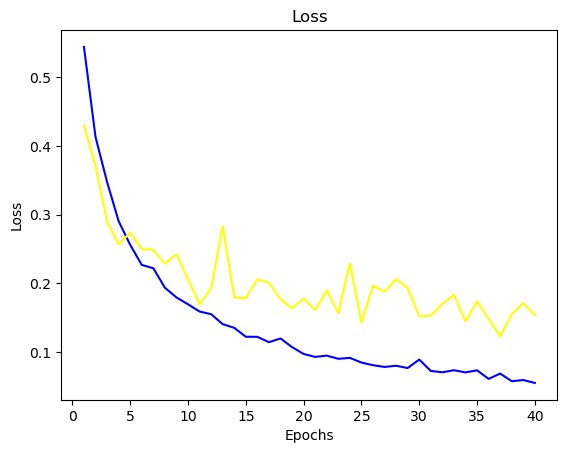

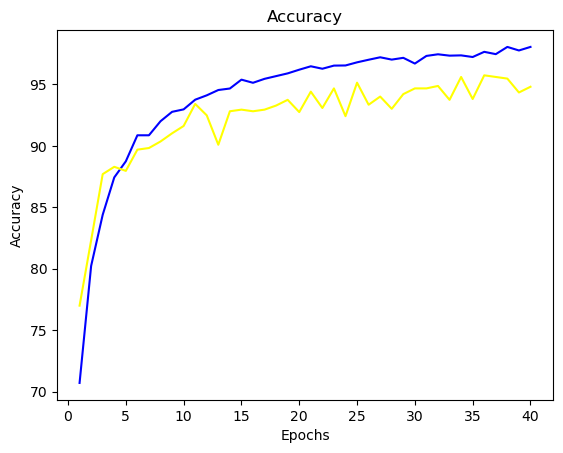

In [18]:
### Plotting Results

#Loss
plt.title("Loss")
plt.plot(np.arange(1, 41, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, 41, 1), val_logs["loss"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

#Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, 41, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, 41, 1), val_logs["accuracy"], color = 'yellow')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

## Testing the model

In [67]:
res_model = resnet50()
res_model.fc = nn.Sequential(nn.Linear(2048, 1, bias = True), nn.Sigmoid())
res_model.load_state_dict(torch.load("resnet50_best.pth"))
res_model.to(device)
res_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [68]:
DIR_TEST = "./data/test/"
test_imgs = os.listdir(DIR_TEST)

In [69]:
def get_test_transform():
    return T.Compose([
        T.ToTensor(),
        T.Normalize((0, 0, 0),(1, 1, 1))
    ])

In [70]:
test_dataset = DeepFakeDataset(test_imgs, mode = "test", transforms = get_test_transform())

test_data_loader = DataLoader(
    dataset = test_dataset,
    # num_workers = 4,
    batch_size = 1,
    shuffle = True
)

In [78]:
### Local Parameters
losses = []
accuracies = []

i = 0
up = 100

    
    ###Iterating over data loader
for images, labels in test_data_loader:
        #Loading images and labels to device
    images = images.to(device)
    labels = labels.to(device)
    labels = labels.reshape((labels.shape[0], 1)) # [N, 1] - to match with preds shape
        
    preds = model(images)
    
    # Calculating Loss
    _loss = criterion(preds, labels)
    loss = _loss.item()
    losses.append(loss)
        
    # Calculating Accuracy
    acc = accuracy(preds, labels)
    accuracies.append(acc)
    
#     To stop after 100
#     i+=1
#     if (i == up):
#         break
        
###Acc and Loss
print("Len of Losses", len(losses))
print("Len of Accuracies", len(accuracies))
losses = np.mean(losses)
accuracies = np.mean(accuracies)
    
print("Loss: ", losses)
print("Accuracy: ", accuracies)

0.009841972962021828
3.6486239433288574
0.009220119565725327
4.686434268951416
4.78574800491333
0.00772147485986352
0.009854191914200783
0.008321120403707027
4.803514003753662
0.008532463572919369
0.03019062429666519
4.612306118011475
4.610029697418213
4.471888065338135
0.011216487735509872
0.02687942050397396
4.782639980316162
0.001857216120697558
4.949216365814209
4.6303229331970215
0.010170445777475834
4.891041278839111
0.010370015166699886
0.010119626298546791
0.0073444475419819355
0.009560002945363522
0.008427747525274754
4.664548397064209
4.738353729248047
0.010518060997128487
4.675050735473633
0.008349789306521416
4.632630825042725
0.00949946604669094
0.02805238962173462
4.841313362121582
6.146585941314697
0.009192327037453651
0.007005016319453716
0.00807599164545536
0.009383698925375938
4.605508804321289
4.835754871368408
0.009462038986384869
4.694554328918457
0.010196639224886894
0.00905175507068634
0.010144012048840523
4.834689140319824
4.603620529174805
4.657754898071289
0.0

In [55]:
print(test_dataset.__len__())

1505
